In [1]:
import pandas as pd
import numpy as np
import itertools
import random
import seaborn as sns
import pickle


from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import learning_curve, validation_curve, train_test_split , KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

from scipy.stats import loguniform, beta, uniform

from imblearn.over_sampling import SMOTE

import missingno as msno

import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# warnings.filterwarnings('ignore')


## Adding Noise (optional)

In [2]:
# Function to insert missing values (imported from Lecture 3 dataset_noiser)
def add_missing(col, amount, random_state=None):
    # X = col.copy()
    X = col.reset_index(drop=True).copy()
    if random_state is not None:
        np.random.seed(random_state)  # Seed for reproducibility
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace=False)
    X[indexes] = np.nan
    return X

The method <code>add_missing</code> inserts a certain quantity of missing values into the column specify by the argument **col**. The level of missing values is defdined by the argument amount. If **amount** is less than 1, it is intended as a percentage, i.e. the percentage of missing values to be inserted into the columns, otherwise it indicates how many missing values we want to insert into the column.
**Update**: To assure the reproducibility of the experiment, **random_state** is used to set the seed. When the function is called, we have to specify a value for **random_state**. This will ensure that the missing values are always inserted in the same way.

In [3]:
# Make a copy of the original dataset to make sure that we don't modify the original dataset
# to prevent the incremention of noisy data everytime we run the notebook.
with open('df_complete.pkl', 'rb') as f:
    custom_df = pickle.load(f)
custom_df.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Total_Purchases',
       'Days_Since_Enrollment', 'Age', 'is_Parent', 'Total_Mnt', 'Total_Cmp'],
      dtype='object')

In [4]:
#Remove columns that are not useful
columns_to_remove = ['Year_Birth', 'Dt_Customer', 'Total_Mnt', 'Total_Purchases', 'Total_Cmp', 'Kidhome', 'Teenhome']
custom_df.drop(columns=columns_to_remove, axis=1, inplace=True)

In [5]:
custom_df

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Since_Enrollment,Age,is_Parent
0,UG,Single,58138.0,58,635,88,546,172,88,88,...,0,0,0,0,0,0,1,4548,65,0
1,UG,Single,46344.0,38,11,1,6,2,1,6,...,0,0,0,0,0,0,0,3998,68,2
2,UG,Relationship,71613.0,26,426,49,127,111,21,42,...,0,0,0,0,0,0,0,4197,57,0
3,UG,Relationship,26646.0,26,11,4,20,10,3,5,...,0,0,0,0,0,0,0,4024,38,1
4,PG,Relationship,58293.0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,0,4046,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,UG,Relationship,61223.0,46,709,43,182,42,118,247,...,0,0,0,0,0,0,0,4266,55,1
2206,PG,Relationship,64014.0,56,406,0,30,0,0,8,...,0,0,0,1,0,0,0,3904,76,3
2207,UG,Single,56981.0,91,908,48,217,32,12,24,...,0,1,0,0,0,0,0,4040,41,0
2208,PG,Relationship,69245.0,8,428,30,214,80,30,61,...,0,0,0,0,0,0,0,4041,66,1


Education                154
Marital_Status           176
Income                   110
Recency                  132
MntWines                 110
MntFruits                154
MntMeatProducts            0
MntFishProducts            0
MntSweetProducts         198
MntGoldProds               0
NumDealsPurchases          0
NumWebPurchases            0
NumCatalogPurchases        0
NumStorePurchases          0
NumWebVisitsMonth          0
AcceptedCmp3             176
AcceptedCmp4               0
AcceptedCmp5               0
AcceptedCmp1               0
AcceptedCmp2               0
Complain                   0
Response                   0
Days_Since_Enrollment    132
Age                      198
is_Parent                 88
dtype: int64

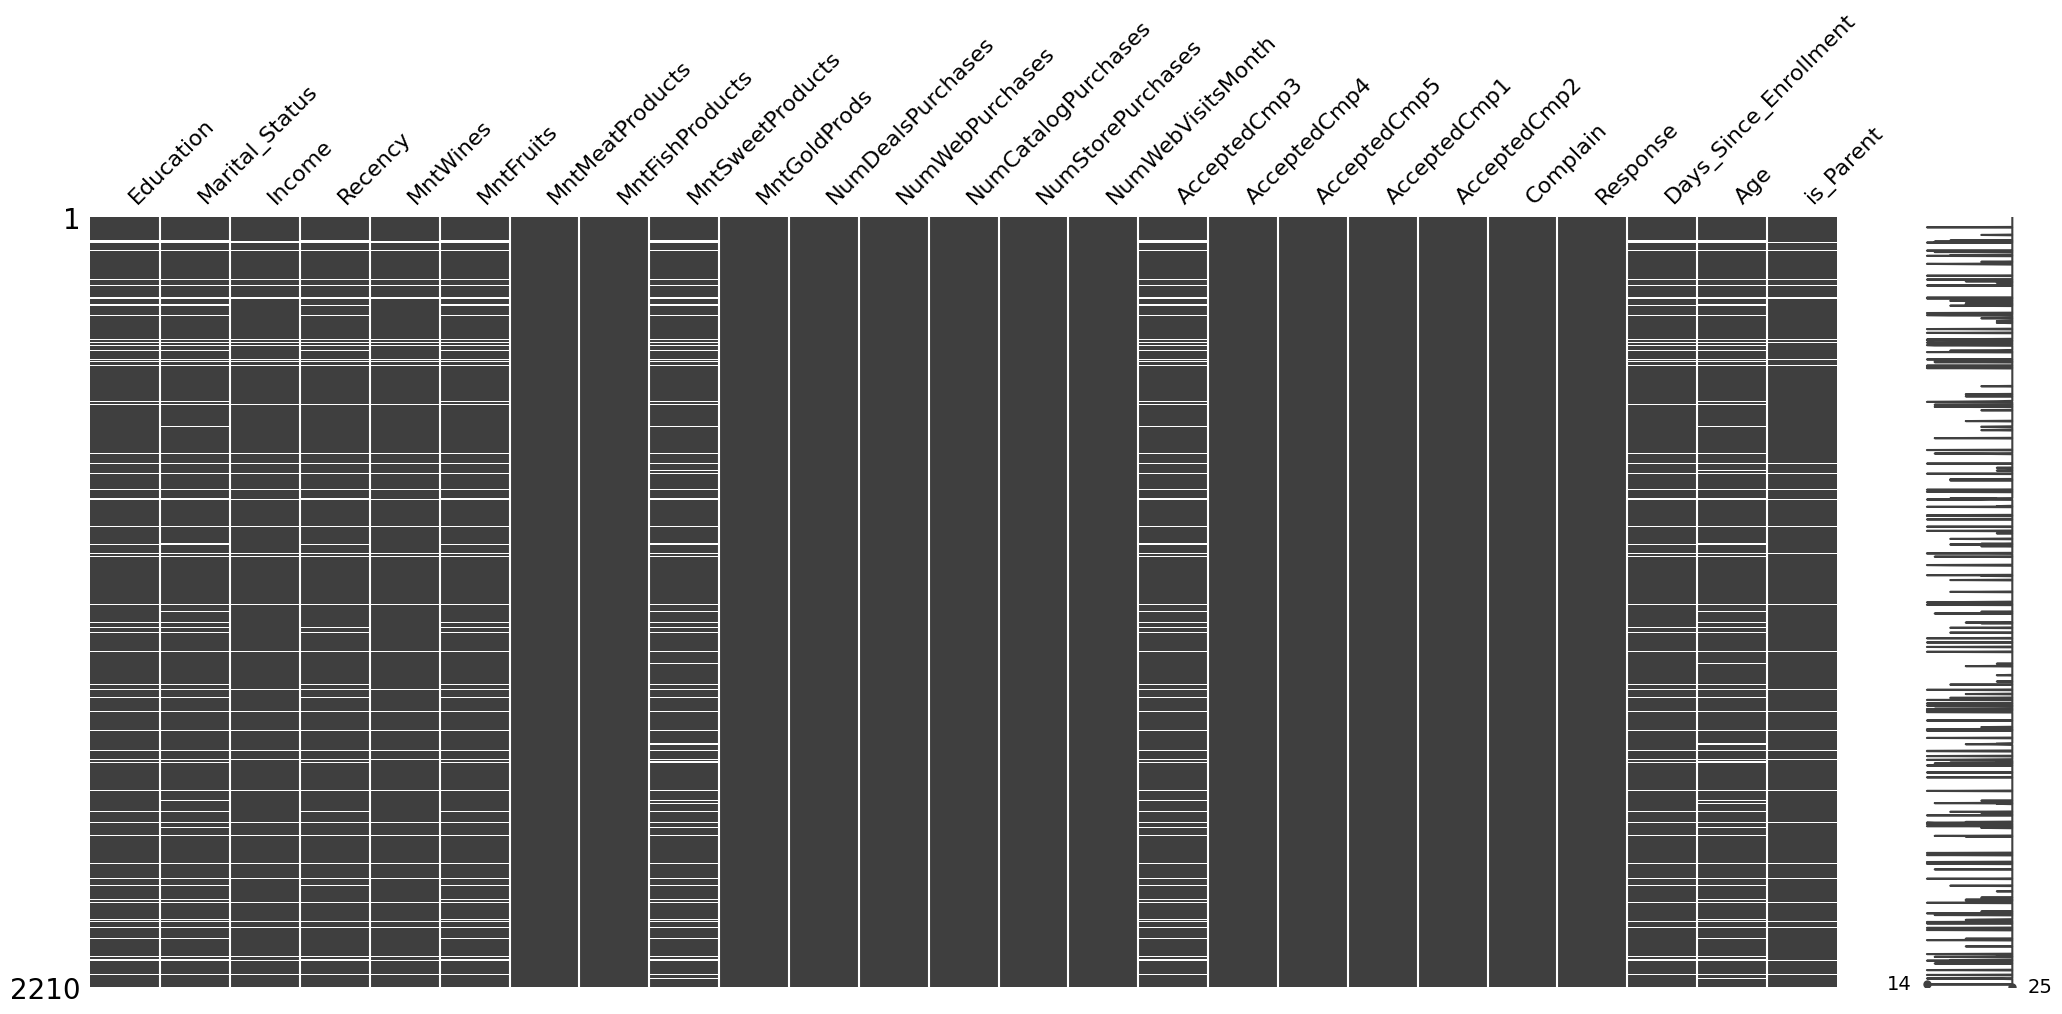

In [6]:
# Add missing values starting always from the original dataset
df_with_missing = custom_df.copy()
df_with_missing['Income'] = add_missing(df_with_missing['Income'], 0.05, random_state=42)
df_with_missing['Recency'] = add_missing(df_with_missing['Recency'], 0.06, random_state=42)
df_with_missing['MntWines'] = add_missing(df_with_missing['MntWines'], 0.05, random_state=42)
df_with_missing['MntFruits'] = add_missing(df_with_missing['MntFruits'], 0.07, random_state=42)
df_with_missing['MntSweetProducts'] = add_missing(df_with_missing['MntSweetProducts'], 0.09, random_state=42)
df_with_missing['Education'] = add_missing(df_with_missing['Education'], 0.07, random_state=42)
df_with_missing['Marital_Status'] = add_missing(df_with_missing['Marital_Status'], 0.08, random_state=42)
df_with_missing['Days_Since_Enrollment'] = add_missing(df_with_missing['Days_Since_Enrollment'], 0.06, random_state=42)
df_with_missing['Age'] = add_missing(df_with_missing['Age'], 0.09, random_state=42)
df_with_missing['AcceptedCmp3'] = add_missing(df_with_missing['AcceptedCmp3'], 0.08, random_state=42)
df_with_missing['is_Parent'] = add_missing(df_with_missing['is_Parent'], 0.04, random_state=42)

# Create a list of columns with missing values
columns_with_missing = df_with_missing.columns[df_with_missing.isnull().any()].tolist()

msno.matrix(df_with_missing)
df_with_missing.isnull().sum(axis=0)

## Data transformation pipeline

Group together the features to insert in the pipeline.

In [7]:
# List of binary features (don't need to be normalized)
binary_features = ['AcceptedCmp3']

# List of numerical features
numerical_features = ['Age', 'Income', 'is_Parent', 'Days_Since_Enrollment', 'Recency', 'MntWines', 
'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds',
'NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases','NumDealsPurchases' , 'NumWebVisitsMonth']

# List of categorical features
categorical_features = ['Education', 'Marital_Status']

Structure the pipelines to insert in the column transformer.

In [8]:
# Pipeline for binary features
binary_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Fill missing values with the most frequent value
])

#Pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('standard_scaler', StandardScaler())  # Scale the data
])

# Pipeline for categorical features
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value
    ('ordinal_encoder', OrdinalEncoder()),  # Encode the categorical data
    ('standard_scaler', StandardScaler())  # Scale the data
])
#Ordinal Encoding for both because using a label encoder on Marital Status would have the same results:
# Single = 1 and Relationship = 0
#Also, label encoding cannot be used in a pipeline.

Define the column transformer.

In [9]:
final_transformation = ColumnTransformer(
    transformers=[
        ('binary_pip', binary_pipeline, binary_features),
        ('numerical_pip', numerical_pipeline, numerical_features),
        ('ordinal_pip', ordinal_pipeline, categorical_features),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough',
    sparse_threshold = 0.5
)

In [10]:
df_with_missing

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Since_Enrollment,Age,is_Parent
0,UG,Single,58138.0,58.0,635.0,88.0,546,172,88.0,88,...,0.0,0,0,0,0,0,1,4548.0,65.0,0.0
1,UG,Single,46344.0,38.0,11.0,1.0,6,2,1.0,6,...,0.0,0,0,0,0,0,0,3998.0,68.0,2.0
2,UG,Relationship,71613.0,26.0,426.0,49.0,127,111,21.0,42,...,0.0,0,0,0,0,0,0,4197.0,57.0,0.0
3,UG,Relationship,26646.0,26.0,11.0,4.0,20,10,3.0,5,...,0.0,0,0,0,0,0,0,4024.0,38.0,1.0
4,PG,Relationship,58293.0,94.0,173.0,43.0,118,46,27.0,15,...,0.0,0,0,0,0,0,0,4046.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,UG,Relationship,61223.0,46.0,709.0,43.0,182,42,118.0,247,...,0.0,0,0,0,0,0,0,4266.0,55.0,1.0
2206,PG,Relationship,64014.0,56.0,406.0,0.0,30,0,0.0,8,...,0.0,0,0,1,0,0,0,3904.0,76.0,3.0
2207,UG,Single,56981.0,91.0,908.0,48.0,217,32,12.0,24,...,0.0,1,0,0,0,0,0,4040.0,41.0,0.0
2208,PG,Relationship,69245.0,8.0,428.0,30.0,214,80,30.0,61,...,0.0,0,0,0,0,0,0,4041.0,66.0,1.0


##  Training and test sets

Now, we can split the entire dataset into training and test sets, putting 30% of the instances in the test set. Remember that we will use the test set only at the end of the model selection process.

In [11]:
X = df_with_missing.drop('Response', axis=1)
y = df_with_missing['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42, shuffle=True)

<code>stratify=y</code> Ensure that the split between train and test sets **respects the proportions of the classes present in the original dataset**. In other words, if your dataset, for example, has 20% class 1 examples and 80% class 0 examples, you will roughly have the same percentages in the train and test sets. This helps to **reduce class imbalance problems** between train and test.

We only <code>fit</code> and <code>transform</code> on the training set to **avoid data leakage**, ensuring the test set remains completely unseen during training. This keeps the model evaluation **unbiased**.
The fit step learns the transformation parameters (e.g., mean and standard deviation for scaling) from the training data. Then we apply those parameters to the test set with transform, mimicking a real-world scenario where new data doesn’t influence model training.

In [12]:
# Transformation of the train and test sets
X_train = final_transformation.fit_transform(X_train)
X_test = final_transformation.transform(X_test)


#Convert the sets into dataframes
X_train = pd.DataFrame(X_train, columns=final_transformation.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=final_transformation.get_feature_names_out())

X_train

,AcceptedCmp3,Age,Income,is_Parent,Days_Since_Enrollment,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebPurchases,NumDealsPurchases,NumWebVisitsMonth,Education,Marital_Status,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain
0,0.0,1.216553e+00,-0.536875,1.398198,-1.325791,0.444113,-0.751473,-0.685185,-0.682445,-0.678739,...,-0.399990,0.359871,0.713450,-1.114464,-0.701287,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.077446e+00,-0.399019,1.398198,-0.679210,0.586150,-0.851250,-0.582669,-0.700760,-0.678739,...,-1.114936,-0.707666,-0.569930,0.897293,1.425950,0.0,0.0,0.0,0.0,0.0
2,0.0,9.518605e-01,-0.847845,2.757862,0.059012,-1.757472,-0.905674,-0.685185,-0.732812,-0.678739,...,-1.114936,-0.707666,0.713450,-1.114464,1.425950,0.0,0.0,0.0,0.0,0.0
3,0.0,-6.269170e-16,0.632999,-1.321132,1.728922,-0.656680,2.087631,2.185256,1.162802,0.104419,...,-0.757463,-0.707666,-0.142137,0.897293,-0.701287,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.342138e+00,-1.300240,0.038533,-1.600715,-0.230566,-0.902650,-0.685185,-0.719075,-0.641446,...,-1.114936,-0.173898,0.713450,-1.114464,-0.701287,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,0.0,-9.009848e-01,0.081144,0.038533,0.272842,-1.118302,-0.709144,0.698778,-0.247461,0.812990,...,-0.042518,-0.173898,-0.142137,-1.114464,-0.701287,0.0,0.0,0.0,0.0,0.0
1543,0.0,6.871683e-01,-0.865180,0.038533,0.720866,-0.798717,-0.811944,-0.685185,-0.737390,-0.678739,...,-1.114936,-0.707666,0.713450,0.897293,1.425950,0.0,0.0,0.0,0.0,0.0
1544,0.0,-9.892155e-01,1.093042,0.038533,0.379757,-1.650944,0.352119,1.262614,1.707677,0.850283,...,1.387373,-0.173898,-0.569930,0.897293,-0.701287,0.0,0.0,0.0,0.0,0.0
1545,0.0,-9.892155e-01,0.732930,1.398198,-0.719940,1.331848,-0.494473,1.108841,-0.261198,0.663817,...,-0.042518,-0.173898,-0.997724,-1.114464,-0.701287,0.0,0.0,0.0,0.0,0.0


In [13]:
#Check for class imbalance
print(y.value_counts(normalize=True))  # Show proportions of each class
print(y.value_counts()) 

Response
0    0.849321
1    0.150679
Name: proportion, dtype: float64
Response
0    1877
1     333
Name: count, dtype: int64


We can clearly see that the target is highly **imbalanced**. Hence, when building the model we will apply the <code>SMOTE</code> method to balance the dataset. It is a resampling techniques to deal with class imbalance which upsamples the minority class.
We repeat instances belonging the minority class till we reach a balance of the enlarge dataset.

In [14]:
# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

/root/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Building the Models

To run faster the code I commented the Grid Search on both Random Forest and Logistic Regression, because I already computed them before. I'll apply directly the hyperparameters found in the grid search on both models. 
- Best parameters for **Logistic Regression**: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'};

In [15]:
# Model 1: Logistic Regression parameter grid
param_grid_lr = {                   # the parameter C is the inverse of the regularization parameter λ, so that
    'C': [0.01, 0.1, 1, 10, 100],   # incresing C, we reduce the regularization.
    'penalty': ['l1', 'l2', None],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': [None, 'balanced'],
}

# 6. Optimize Logistic Regression using GridSearchCV
# clf_lr = LogisticRegression(random_state=42, max_iter=1000)
# grid_lr = GridSearchCV(clf_lr, param_grid_lr, cv=StratifiedKFold(n_splits=5), scoring='roc_auc',  return_train_score=True)
# grid_lr.fit(X_train_balanced, y_train_balanced)

clf_lr = LogisticRegression(random_state=42, max_iter=1000, C=1, class_weight='balanced', penalty='l1', solver='saga')
clf_lr.fit(X_train_balanced, y_train_balanced)

# print("Best parameters for Logistic Regression:", grid_lr.best_params_)
# print("Best CV ROC-AUC for Logistic Regression:", grid_lr.best_score_)

# ROC AUC indicates how well the model can separate the positive class from 
# the negative class across all possible threshold settings.
# - 1.0 means a perfect classifier.
# - 0.5 means the model is no better than random guessing.

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')

- Best parameters for **RandomForest**: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200};


In [16]:
# Modello 2: RandomForestClassifier parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'class_weight': [None, 'balanced'],
    'max_features': ['sqrt', 'log2'],  # Sostituito 'auto' con 'sqrt'
    'max_depth' : [3,4, 6,8,10],   #"None" removed
    'criterion' :['gini'],
    'min_samples_split':[2,3,4, 5, 6, 7],
    'min_samples_split': [3, 5, 8, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# 7. Optimize RandomForestClassifier using GridSearchCV
# clf_rf = RandomForestClassifier(random_state=42)
# grid_rf = GridSearchCV(clf_rf, param_grid_rf, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', return_train_score=True)
# grid_rf.fit(X_train_balanced, y_train_balanced)

clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced', criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=3, n_estimators=200)
clf_rf.fit(X_train_balanced, y_train_balanced)
# print("Best parameters for RandomForest:", grid_rf.best_params_)
# print("Best CV ROC-AUC for RandomForest:", grid_rf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200, random_state=42)

In [17]:
# 8. Create a VotingClassifier (soft voting) using the best estimators
# voting_clf = VotingClassifier(
#     estimators=[('lr', grid_lr.best_estimator_), ('rf', grid_rf.best_estimator_)],
#     voting='soft'
# )

voting_clf = VotingClassifier(
    estimators=[('lr', clf_lr), ('rf', clf_rf)],
    voting='soft' # The class with the highest average probability is chosen.
)

The **outer cross-validation (shown here)** gives you an unbiased estimate of how the final VotingClassifier generalizes to unseen data.

In [18]:
# 9. Evaluate the VotingClassifier using Nested Cross-Validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(voting_clf, X_train_balanced, y_train_balanced, cv=outer_cv, scoring='roc_auc')
print("Nested CV ROC-AUC Score for VotingClassifier:", nested_scores.mean())

Nested CV ROC-AUC Score for VotingClassifier: 0.9650841080795693


In [19]:
# 10. Fit the final VotingClassifier on the balanced training set
voting_clf.fit(X_train_balanced, y_train_balanced)
print("\nFinal VotingClassifier trained with the following models:")
# print(" -> Logistic Regression:", grid_lr.best_estimator_)
# print(" -> RandomForest:", grid_rf.best_estimator_)

print(" -> Logistic Regression:", clf_lr)
print(" -> RandomForest:", clf_rf)


Final VotingClassifier trained with the following models:
 -> Logistic Regression: LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
 -> RandomForest: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200, random_state=42)


In [20]:
# 11. Evaluate the final model on the test set
# grid_rf.best_estimator_.fit(X_train_balanced, y_train_balanced)
voting_clf.fit(X_train_balanced, y_train_balanced)

y_test_pred = voting_clf.predict(X_test)
y_train_pred = voting_clf.predict(X_train)
y_proba = voting_clf.predict_proba(X_test)[:, 1] # Gets the predicted probabilities of the positive class (index 1)
# y_pred = grid_rf.best_estimator_.predict(X_test)                                # for each sample in X_test.
# y_proba = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_proba)

# Print the Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("\nTest ROC-AUC Score:", test_roc_auc)
print("Classification Report on Test Set:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, y_test_pred))

Accuracy: 0.8627450980392157

Test ROC-AUC Score: 0.9031971580817051
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       563
           1       0.53      0.73      0.62       100

    accuracy                           0.86       663
   macro avg       0.74      0.81      0.77       663
weighted avg       0.89      0.86      0.87       663

Confusion Matrix on Test Set:
 [[499  64]
 [ 27  73]]


Let's try to train a BaggingClassifier with the DecisionTree as base estimator and see if it performs better than Random Forest.

In [21]:
# Define the base estimator - a DecisionTreeClassifier
base_dt = DecisionTreeClassifier(random_state=42)

# Create the BaggingClassifier with the DecisionTree as base estimator
bagging_dt = BaggingClassifier(
    estimator=base_dt,
    n_estimators=20,          # Number of decision trees to aggregate
    max_samples=0.8,          # Fraction of samples to draw for each estimator
    max_features=0.8,         # Fraction of features to draw for each estimator
    random_state=42,
    n_jobs=-1                 # Use all available cores
)

# Train the BaggingClassifier on the balanced training set
bagging_dt.fit(X_train_balanced, y_train_balanced)

# Evaluate the model on the test set
y_pred = bagging_dt.predict(X_test)
y_proba = bagging_dt.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("BaggingClassifier (Decision Tree) Test ROC-AUC:", roc_auc)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8763197586726998
BaggingClassifier (Decision Tree) Test ROC-AUC: 0.8641651865008881
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       563
           1       0.61      0.50      0.55       100

    accuracy                           0.88       663
   macro avg       0.76      0.72      0.74       663
weighted avg       0.87      0.88      0.87       663

Confusion Matrix:
 [[531  32]
 [ 50  50]]


## Learning Curves

To check if the models are overfitting (or underfitting), we can plot the learning curve. We can report the accuracy of the model on the training and validation set as a function of the size of the training set, obtaining the learning curve .

In [22]:
def plot_learning_curve(train_sizes, train_scores, valid_scores, title_txt, xlabel_txt, ylabel_txt):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation Score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                    valid_scores_mean + valid_scores_std, alpha=0.1, color='g')
    plt.title('Learning Curve - ' + title_txt)
    plt.xlabel(xlabel_txt)
    plt.ylabel(ylabel_txt)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

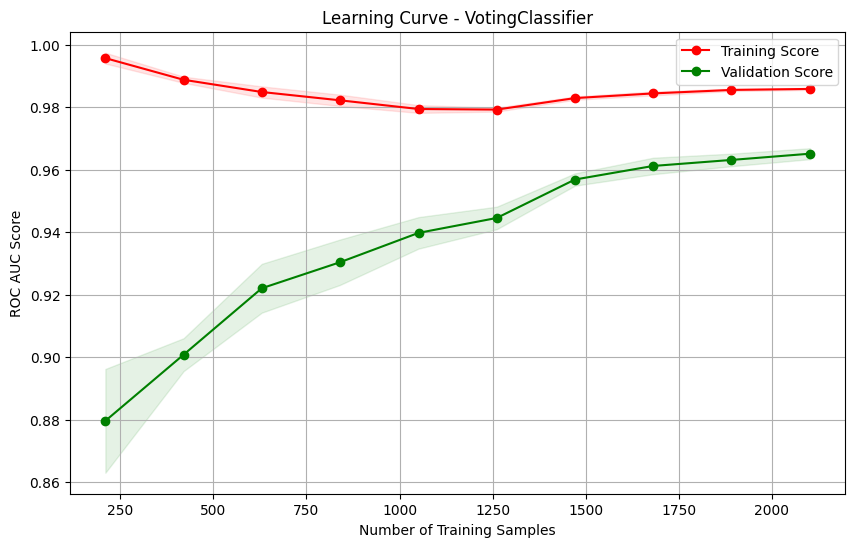

In [23]:
#VALIDATION CURVE FOR VOTING CLASSIFIER

# Suppose voting_clf is your pre-built VotingClassifier
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, valid_scores = learning_curve(
    voting_clf, X_train_balanced, y_train_balanced, cv=cv,
    scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
plot_learning_curve(train_sizes, train_scores, valid_scores, 'VotingClassifier', 'Number of Training Samples', 'ROC AUC Score')

**Voting Classifier** (Random Forest, Logistic Regression)

- The training score is very **high and stable** (almost 1.0), which suggests an excellent fit on the training data.
- The validation score is **lower**, but it shows _improvement with increasing data_.
- There might be **some overfitting** with low training samples, but _overall the model is quite stable_.

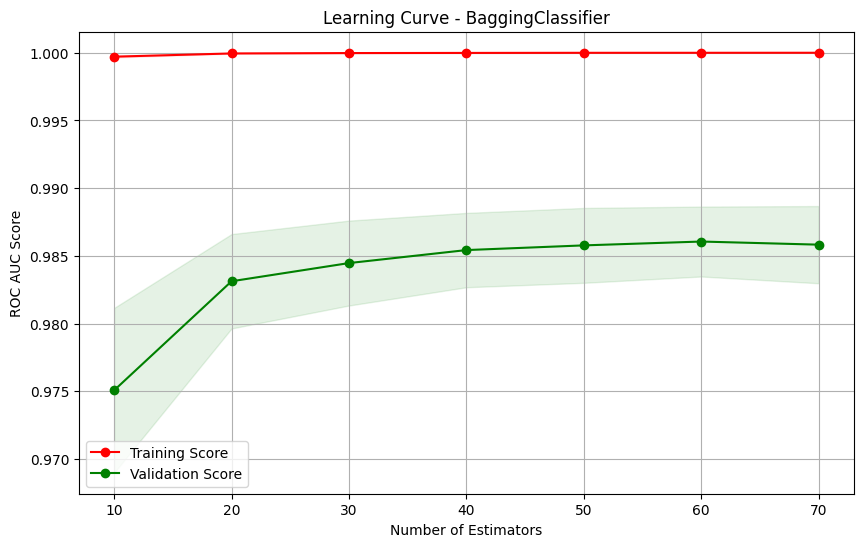

In [24]:
#VALIDATION CURVE FOR BAGGINGCLASSIFIER

# Suppose bagging_dt is your BaggingClassifier based on Decision Trees
# We vary an iperparameter, ad esempio 'n_estimators'
param_range = [10, 20, 30, 40, 50, 60, 70]
train_scores, valid_scores = validation_curve(
    bagging_dt, X_train_balanced, y_train_balanced,
    param_name='n_estimators', param_range=param_range,
    cv=cv, scoring='roc_auc', n_jobs=-1
)

plot_learning_curve(param_range, train_scores, valid_scores, 'BaggingClassifier', 'Number of Estimators', 'ROC AUC Score')

**BaggingClassifier** (Decision Tree)

- The training score is consistently 1.0, which indicates severe **overfitting**.
- The validation score is relatively high (~0.98), but there is a more significant difference compared to the training score. 
- Bagging has reduced the variance compared to a single Decision Tree, but the overfitting issue persists.

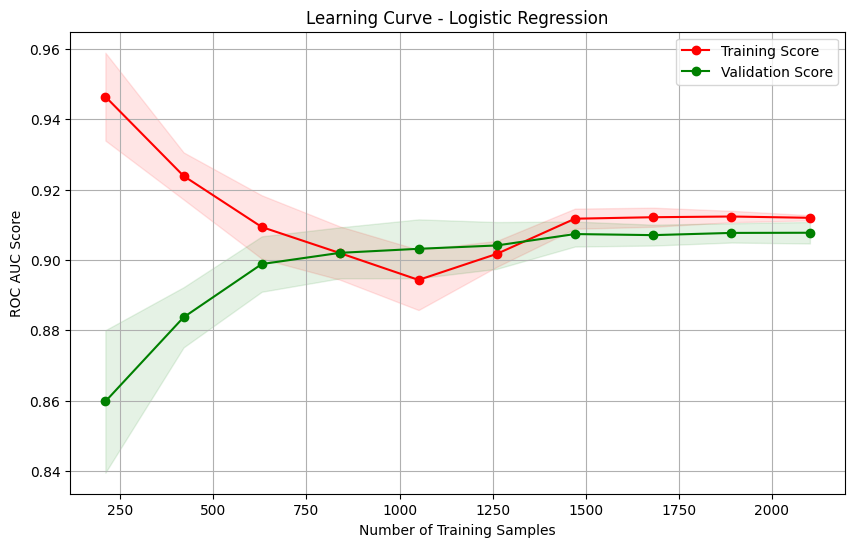

In [25]:
# Logistic Regression Learning Curve

# --- Learning Curve ---
# Define the model (here we use the best Logistic Regression found from GridSearch)

# model = grid_lr.best_estimator_
model = clf_lr

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train_balanced, y_train_balanced,
    cv=cv, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plot_learning_curve(train_sizes, train_scores, valid_scores, 'Logistic Regression', 'Number of Training Samples', 'ROC AUC Score')

**Logistic Regression**

- The training score starts high,indicating that with few data the model fits too well to the training data without generalizing correctly, but decreases with increasing data, stabilizing close to the validation score. 
- The validation score is very close to the training score, suggesting that the model has good generalization. 
- The two curves converge towards a value of around 0.90-0.91. This convergence is a positive signal: it means that adding more data helps the model reduce the gap between bias and variance, improving generalization 
- This is the most 'conservative' model, less prone to overfitting, but it may be less powerful compared to ensemble methods. Being a linear model, it tends to be more stable but less capable of capturing non-linear complexities in the data.

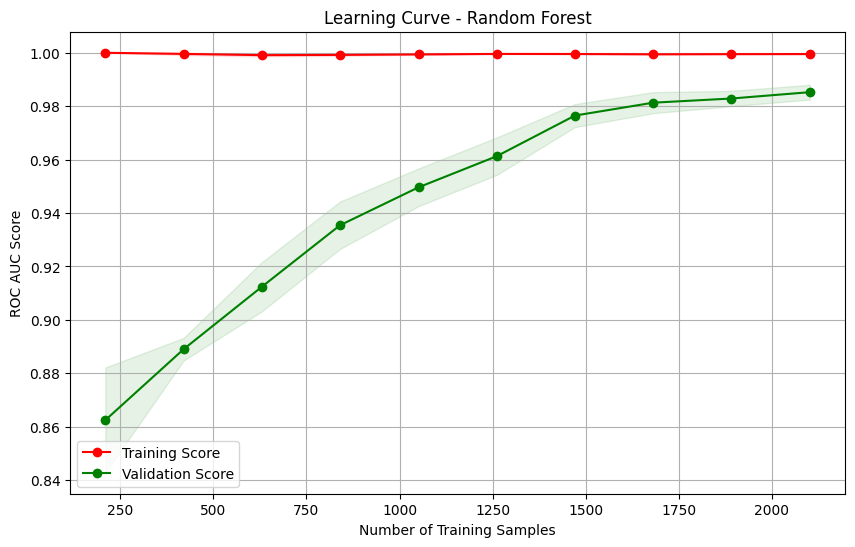

In [26]:
# Random Forest Learning Curve

# --- Learning Curve ---
# Define the model (here we use the best Logistic Regression found from GridSearch)

# model = grid_rf.best_estimator_
model = clf_rf

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train_balanced, y_train_balanced,
    cv=cv, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plot_learning_curve(train_sizes, train_scores, valid_scores, 'Random Forest', 'Number of Training Samples', 'ROC AUC Score')

**Random Forest**

- The training score is always close to 1.0, suggesting overfitting.
- The validation score progressively improves and stabilizes at a high value (~0.98). -This suggests that the model effectively uses the extra information to reduce the overfitting effect and improve generalization. This is a good sign: despite the overfitting, the model generalizes well.
- Despite the perfect fit on the training data, the model achieves very high validation performance (≈0.98). This indicates that, despite its high complexity, the Random Forest greatly benefits from the increase in data, allowing it to achieve very high performance.

**Which Model to Choose?**
If our goal is to maximize performance, Random Forest and VotingClassifier seem to be the best options.

If we want a good balance between bias and variance, VotingClassifier might be preferable to a pure Random Forest because it combines Logistic Regression and Random Forest, thus mitigating overfitting.

If we want to completely avoid overfitting, Logistic Regression is the most robust choice, but it might not have the same predictive power as Random Forest.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d915a820-0830-418f-b947-1fc3a7a60f4d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>